# Линейные модели в машинном обучении

Фермер, владелец молочного хозяйства «Вольный луг» хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма». 

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Фермер просит разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нужно создать две прогнозные модели для отбора бурёнок в поголовье:

1. Первая будет прогнозировать возможный удой коровы (целевой признак `Удой`);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак `Вкус молока`).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

**Описание данных**
1. Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент.
    * `id` — уникальный идентификатор коровы.
    * `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
    * `ЭКЕ` (Энергетическая кормовая единица) — показатель питательности корма коровы.
    * `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
    * `СПО` (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
    * `Порода` — порода коровы.
    * `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    * `порода папы_быка` — порода папы коровы.
    * `Жирность,%` — содержание жиров в молоке (в процентах).
    * `Белок,%` — содержание белков в молоке (в процентах).
    * `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
    * `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`).

    Для лучшего понимания, как взаимосвязаны признаки в датасете их можно разделить на группы:
     - Характеристики коровы: `id`, `Порода`, `порода папы_быка`, `Возраст`.
     - Характеристики корма: `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г,` `СПО (Сахаро-протеиновое соотношение)`.
     - Характеристика пастбища: `Тип пастбища`.
     - Характеристики молока: `Удой, кг`, `Жирность,%`, `Белок,%`, `Вкус молока`.

2. Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера.
    * `id` — уникальный идентификатор коровы.
    * `Имя Папы` — имя папы коровы.

3. Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.
    * `Порода` — порода коровы.
    * `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    * `порода папы_быка` — порода папы коровы.
    * `Имя_папы` — имя папы коровы.
    * `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
    * `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
    * `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`).

Данные в файлах `ferma_main.csv` и `cow_buy.csv` похожи, но у датасета `cow_buy.csv` несколько особенностей.
* Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
* Параметры корма `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)` отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
* Кроме того, отсутствуют признаки `Удой, кг` и `Вкус молока`. Это целевые признаки, именно их предстоит предсказать!

In [1]:
# Импорты библиотек для проекта
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, 
                             confusion_matrix)

### Константы

In [2]:
RANDOM_STATE = 42

### Функции

In [3]:
# Функция для построения boxplot и hist
def box_hist_plot(df, column, bins, plot_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    df.boxplot(column=column, ax=axes[0])
    axes[0].set_title(f'Boxplot {plot_name}')
    axes[0].tick_params(axis='x', labelbottom=False)
    axes[0].set_ylabel(column)

    df[column].hist(bins=bins, ax=axes[1])
    axes[1].set_title(f'Histogram {plot_name}')
    axes[1].set_xlabel(column)
    
    fig.suptitle(plot_name, y=1.05)

    display(df[column].describe())
    IQR = df[column].describe()['75%'] - df[column].describe()['25%']
    Q1_minus = df[column].describe()['25%'] - 1.5 * IQR
    Q3_plus = df[column].describe()['75%'] + 1.5 * IQR
    
    print(f"Усы боксплота: ({Q1_minus}, {Q3_plus})")

# Функция для построения pie chart
def pie_chart(df, column, plot_name):

    allvals_sum = df.shape[0] 
    dt_temp = df.pivot_table(index=column, aggfunc='count')
    dt = dt_temp[dt_temp.columns[0]]
    
    dt_legend = df.pivot_table(index=column, aggfunc='count').reset_index()[column].tolist()
    

    def func(pct):
        absolute = float(pct/100.*allvals_sum)
        return "{:.1f}%\n({:.0f})".format(pct, absolute)

    fig, ax = plt.subplots(figsize=(12, 5), subplot_kw=dict(aspect="equal"))

    wedges, texts, autotexts = ax.pie(dt, autopct=lambda pct: func(pct), textprops=dict(color="w"))

    ax.legend(wedges, dt_legend,
            # title="",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size = 8, weight ="bold")
    ax.set_title(plot_name)

    # show plot
    plt.show()

In [4]:
# Функция построения погрупповой диаграммы рассеяния
def scat_plot(x, ferma_main_df, cat_list, rus_dict, num_rows, num_cols):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
    axes = axes.flatten()

    for i, cat in enumerate(cat_list):
        sns.scatterplot(data=ferma_main_df, x=x, y="yield_kg", hue=cat, style=cat, ax=axes[i])
        axes[i].set_title(f'ScatterPlot Удой, кг и {rus_dict[x]} ({rus_dict[cat]})')
        # plt.legend(title=rus_dict[cat])

    # Удаление пустых subplots если число категорий нечетное
    if len(cat_list) % 2 != 0:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

In [5]:
# Функция построения линейной модели прстой линейной регрессии и расчета метрик
def linear_model(df, cat_cols, quant_cols):
    X = df.drop('yield_kg', axis=1) 
    y = df['yield_kg']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE 
    )

    # Кодирование категор. признаков 
    encoder = OneHotEncoder(sparse=False, drop='first')
    X_train_ohe = encoder.fit_transform(X_train[cat_cols]) # настройка и кодирование по тренир. выборке 
    X_test_ohe = encoder.transform(X_test[cat_cols]) 
    encoder_col_names = encoder.get_feature_names_out()
    df_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names) 
    df_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names) 

    # Масштабирование колич. признаков cтандартизацией
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[quant_cols]) # настройка и масштабирование по тренир. выборке
    X_test_scaled = scaler.transform(X_test[quant_cols])
    df_train_scaled = pd.DataFrame(X_train_scaled, columns=quant_cols) 
    df_test_scaled = pd.DataFrame(X_test_scaled, columns=quant_cols) 

    # Объединение масштабир. и кодиров. входных признаков в новые тестовые и трениров. выборки
    X_train = pd.concat([df_train_scaled, df_train_ohe], axis=1)
    X_test = pd.concat([df_test_scaled, df_test_ohe], axis=1)

    # Обучение 1-ой модели
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    # Оценка кач-ва модели 
    predictions = model_lr.predict(X_test)
    r2 = r2_score(y_test, predictions)
    print(f'Значение коэффициента детерминации R2 модели: {r2}') 
    print(f'Значение MSE модели: {mean_squared_error(y_test, predictions)}')
    print(f'Значение RMSE модели: {mean_squared_error(y_test, predictions, squared=False)}')
    print(f'Значение MAE модели: {mean_absolute_error(y_test, predictions)}') 
    print('-' * 60)

    # Анализ остатков
    y_res = (y_test - predictions).reset_index(drop=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].scatter(x=predictions, y=y_res)
    axes[0].set_title("Диаграмма рассеивания остатков модели")

    bins = plt.hist(y_res, bins=15)
    axes[1].hist(y_res, bins=15)
    axes[1].vlines(x=0, colors='blue', ymin=bins[0].min(), ymax=bins[0].max(), label="0")
    axes[1].vlines(x=y_res.median(), colors='green', ymin=bins[0].min(), ymax=bins[0].max(), label="median")
    axes[1].set_title("Гистограмма остатков модели")
    axes[1].legend()

    plt.show()

    return model_lr, predictions, encoder, scaler, X_train, X_test

## Загрузка данных и общая информация

In [6]:
ferma_main_df = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';')
ferma_dad_df = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';')
cow_buy_df = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';')

In [7]:
display(ferma_main_df.head(10))
print('-----------------------')
ferma_main_df.info()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет
5,6,5254,"12,7",1806,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,13","3,078",вкусно,менее_2_лет
6,7,5910,"13,2",1792,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,48","3,077",вкусно,более_2_лет
7,8,6179,"14,7",1806,"0,93",Вис Бик Айдиал,Равнинные,Айдиал,"3,55","3,076",вкусно,более_2_лет
8,9,6783,"14,2",1918,"0,94",РефлешнСоверинг,Холмистое,Айдиал,"3,71","3,077",вкусно,более_2_лет
9,10,5339,"13,4",1791,"0,895",Вис Бик Айдиал,Холмистое,Соверин,"3,13","3,075",вкусно,менее_2_лет


-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object


Пропущенных значений в `ferma_main_df` нет. Столбцы `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,% ` и `Белок,%` имеют несоответствующий тип данных. Для дальнейшей работы приведем названия столбцов к нужному виду.

In [8]:
ferma_main_df = ferma_main_df.rename(columns={'Удой, кг': 'yield_kg', 
                                              'ЭКЕ (Энергетическая кормовая единица)': 'efu', 
                                              'Сырой протеин, г': 'raw_protein_gramm',
                                              'СПО (Сахаро-протеиновое соотношение)' : 'spr',
                                              'Порода' : 'breed',
                                              'Тип пастбища': 'pasture_type',
                                              'порода папы_быка': 'dadbull_breed',
                                              'Жирность,%': 'fatness_perc',
                                              'Белок,%': 'protein_perc',
                                              'Вкус молока': 'milk_taste',
                                              'Возраст': 'age'
                                            })

In [9]:
display(ferma_dad_df.head(10))
print('-----------------------')
ferma_dad_df.info()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Пропущенных значений в `ferma_dad_df` нет. Столбцы имеют соответствующий тип данных. Для дальнейшей работы приведем названия столбцов к нужному виду.

In [10]:
ferma_dad_df = ferma_dad_df.rename(columns={'Имя Папы': 'dadbull_name'})

In [11]:
display(cow_buy_df.head(10))
print('-----------------------')
cow_buy_df.info()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,57","3,079",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,079",менее_2_лет


-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Пропущенных значений в `cow_buy_df` нет. Столбцы `Текущая_жирность,%` и `Текущий_уровень_белок,%` имеют несоответствующий тип данных. Для дальнейшей работы приведем названия столбцов к нужному виду.

In [12]:
cow_buy_df = cow_buy_df.rename(columns={'Порода' : 'breed',
                                        'Тип пастбища': 'pasture_type',
                                        'порода папы_быка': 'dadbull_breed', 
                                        'Имя_папы': 'dadbull_name',
                                        'Текущая_жирность,%': 'fatness_perc_act',
                                        'Текущий_уровень_белок,%': 'protein_perc_act',
                                        'Возраст': 'age'
                                        })

## Предобработка данных

### Приведение столбцов к соответствующим типам данных

In [13]:
fm_list = ['efu', 'spr', 'fatness_perc', 'protein_perc']
cb_list = ['fatness_perc_act', 'protein_perc_act']

# Приведение в числовой тип ferma_main_df
for i in fm_list:
    ferma_main_df[i] = pd.to_numeric(ferma_main_df[i].str.replace(',', '.'), errors='coerce')

# Приведение в числовой тип cow_buy_df
for i in cb_list:
    cow_buy_df[i] = pd.to_numeric(cow_buy_df[i].str.replace(',', '.'), errors='coerce')
    
# Приведем к нижнему регистру столбец `pasture_type` ferma_main_df (для совпадения с таковым у cow_buy_df)
ferma_main_df['pasture_type'] = ferma_main_df['pasture_type'].str.lower()

### Проверка на дубликаты

#### Поиск явных дубликатов

In [14]:
# Поиск явных дубликатов в ferma_main_df
ferma_main_df.duplicated().sum()

5

In [15]:
# Поиск явных дубликатов в cow_buy_df
cow_buy_df.duplicated().sum()

4

In [16]:
# Удаление явных дубликатов
ferma_main_df = ferma_main_df.drop_duplicates()
# cow_buy_df = cow_buy_df.drop_duplicates()

#### Поиск неявных дубликатов

In [17]:
# Поиск неявных дубликатов в ferma_main_df
ferma_main_df['breed'].value_counts()

Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: breed, dtype: int64

In [18]:
ferma_main_df['pasture_type'].value_counts()


холмистое    351
равнинное    253
равнинные     25
Name: pasture_type, dtype: int64

In [19]:
# Меняем дубликат "равнинные" на "равнинное"
ferma_main_df = ferma_main_df.replace(['равнинные'], 'равнинное')

In [20]:
ferma_main_df['dadbull_breed'].value_counts()

Соверин    311
Айдиал     240
Айдиалл     78
Name: dadbull_breed, dtype: int64

In [21]:
# Меняем дубликат "Айдиалл" на "Айдиал"
ferma_main_df = ferma_main_df.replace(['Айдиалл'], 'Айдиал')

In [22]:
ferma_main_df['milk_taste'].value_counts()

вкусно       371
не вкусно    258
Name: milk_taste, dtype: int64

In [23]:
ferma_main_df['age'].value_counts()

более_2_лет    519
менее_2_лет    110
Name: age, dtype: int64

В `ferma_main_df` найдено 103 неявных дубликата.

In [24]:
# Поиск неявных дубликатов в ferma_dad_df
ferma_dad_df['dadbull_name'].value_counts()

Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: dadbull_name, dtype: int64

In [25]:
# Поиск неявных дубликатов в cow_buy_df
cow_buy_df['breed'].value_counts()

РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: breed, dtype: int64

In [26]:
cow_buy_df['pasture_type'].value_counts()

равнинное    11
холмистое     9
Name: pasture_type, dtype: int64

In [27]:
cow_buy_df['dadbull_breed'].value_counts()

Соверин    12
Айдиал      8
Name: dadbull_breed, dtype: int64

In [28]:
cow_buy_df['age'].value_counts()

более_2_лет    15
менее_2_лет     5
Name: age, dtype: int64

Неявных дубликатов в `cow_buy_df` и `ferma_dad_df` не найдено.

## Исследовательский анализ данных

### Статистический анализ датасета  о стаде фермера `ferma_main_df`

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: yield_kg, dtype: float64

Усы боксплота: (4626.0, 7626.0)


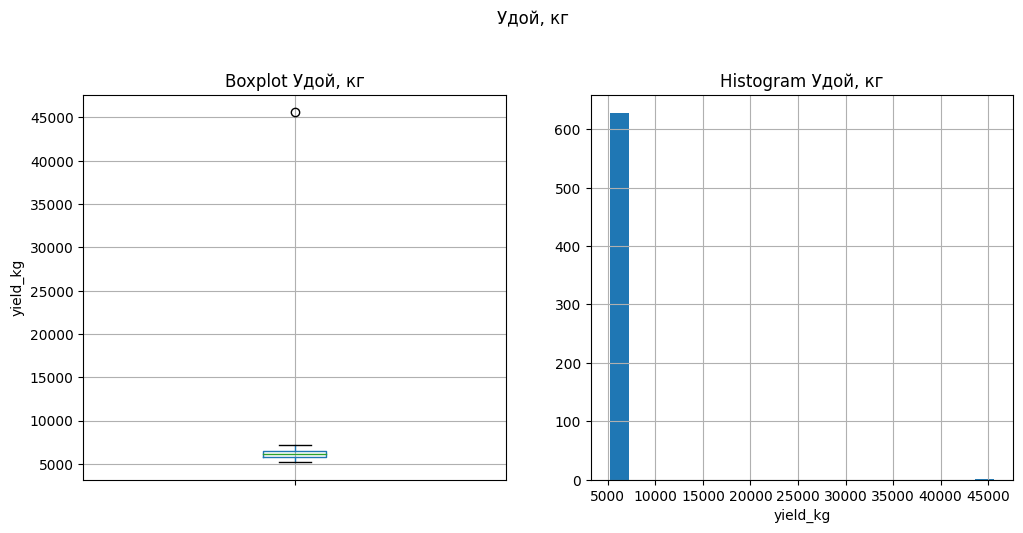

In [29]:
box_hist_plot(ferma_main_df, 'yield_kg', 20, 'Удой, кг')

Удалим очевидный выброс со значением 45 616 и построим графики снова.

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: yield_kg, dtype: float64

Усы боксплота: (4622.875, 7627.875)


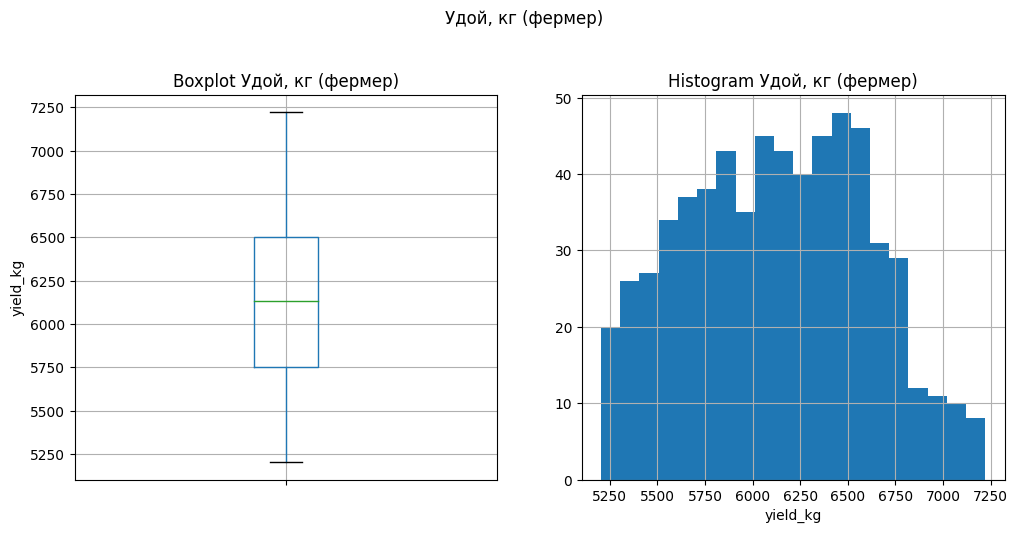

In [30]:
ferma_main_df = ferma_main_df[ferma_main_df['yield_kg'] != 45616]
box_hist_plot(ferma_main_df, 'yield_kg', 20, 'Удой, кг (фермер)')

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: efu, dtype: float64

Усы боксплота: (10.350000000000001, 18.75)


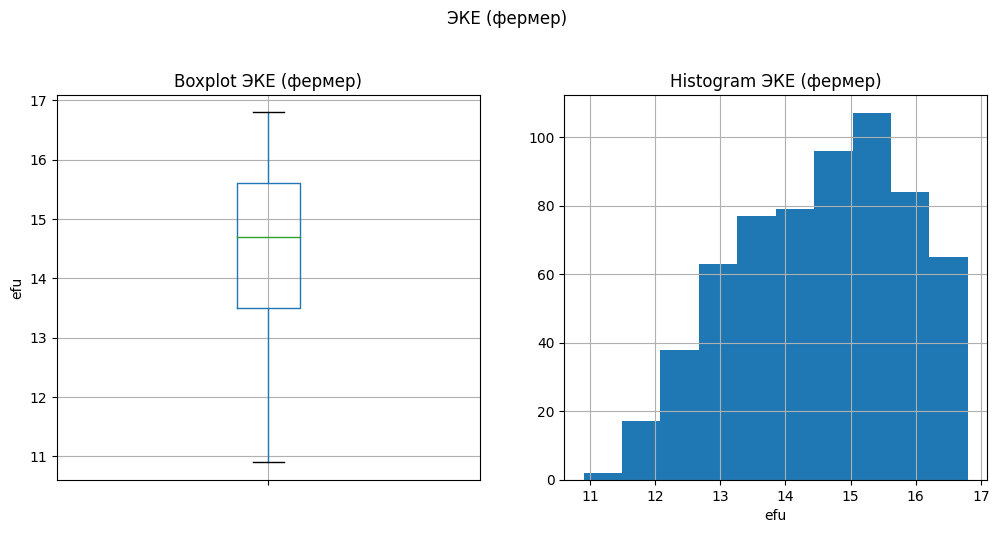

In [31]:
box_hist_plot(ferma_main_df, 'efu', 10, 'ЭКЕ (фермер)')

Выбросов в параметре `efu` не обнаружено. 

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: raw_protein_gramm, dtype: float64

Усы боксплота: (1336.0, 2498.0)


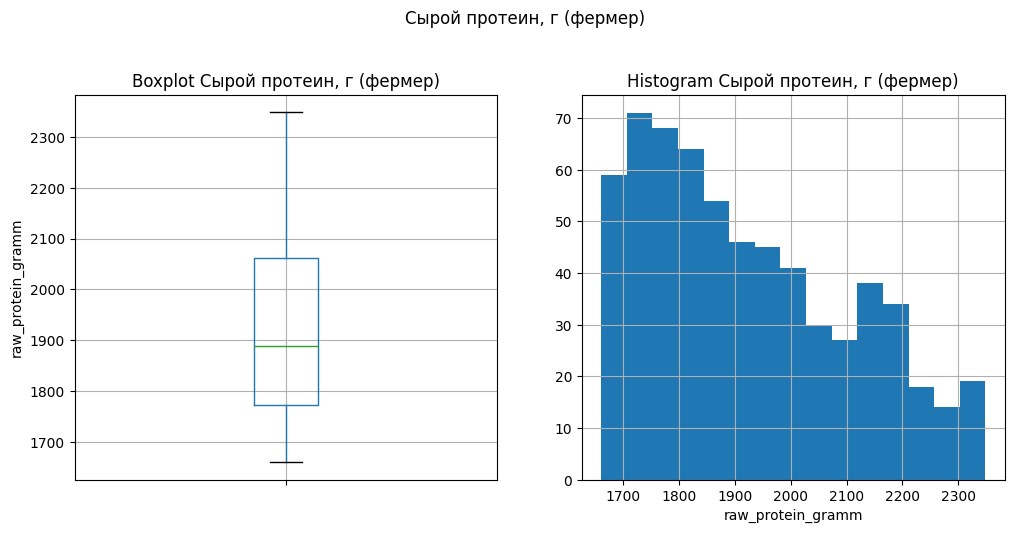

In [32]:
box_hist_plot(ferma_main_df, 'raw_protein_gramm', 15, 'Сырой протеин, г (фермер)')

Выбросов в параметре `raw_protein_gramm` не обнаружено. 

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: spr, dtype: float64

Усы боксплота: (0.8150000000000002, 1.015)


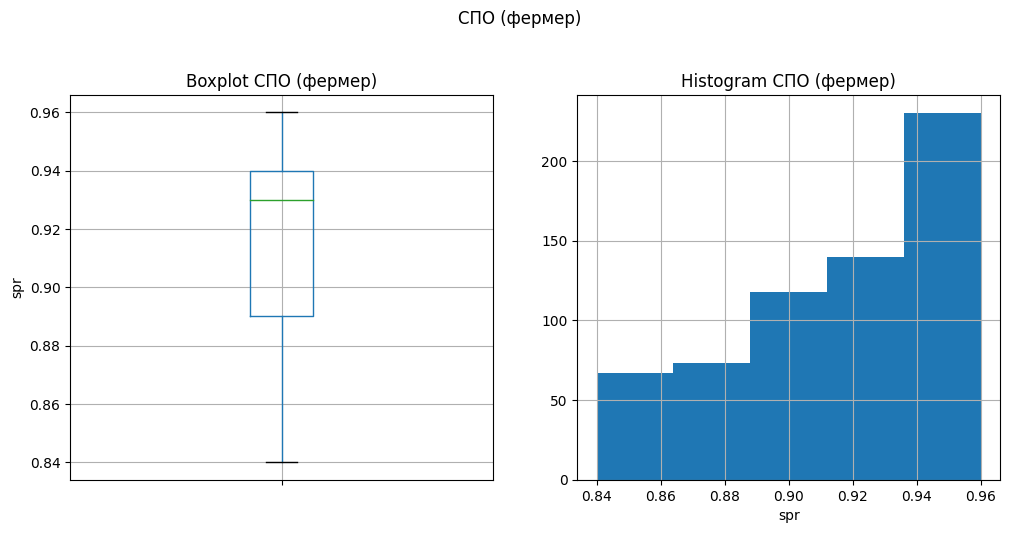

In [33]:
box_hist_plot(ferma_main_df, 'spr', 5, 'СПО (фермер)')

Выбросов в параметре `spr` не обнаружено. 

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fatness_perc, dtype: float64

Усы боксплота: (3.3949999999999996, 3.915000000000001)


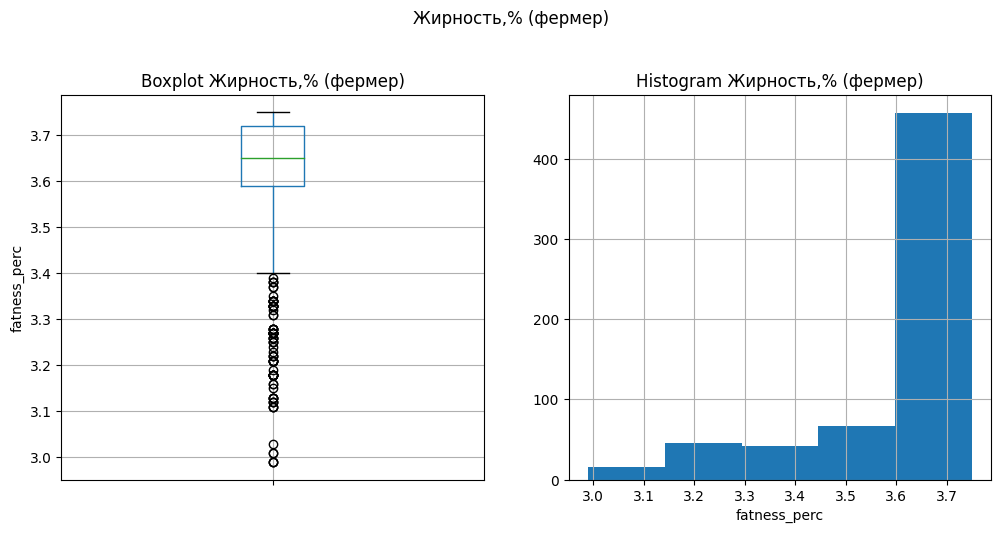

In [34]:
box_hist_plot(ferma_main_df, 'fatness_perc', 5, 'Жирность,% (фермер)')

В параметре `fatness_perc` обнаружено заметное кол-во выбросов.   

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein_perc, dtype: float64

Усы боксплота: (3.0694999999999997, 3.0815)


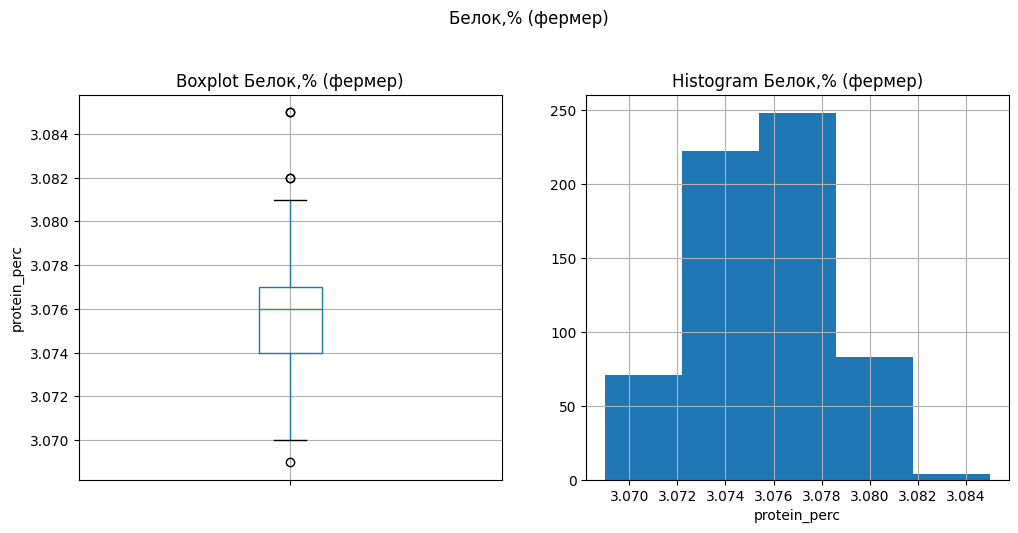

In [35]:
box_hist_plot(ferma_main_df, 'protein_perc', 5, 'Белок,% (фермер)')

В параметре `protein_perc` обнаружено небольшое кол-во выбросов.   

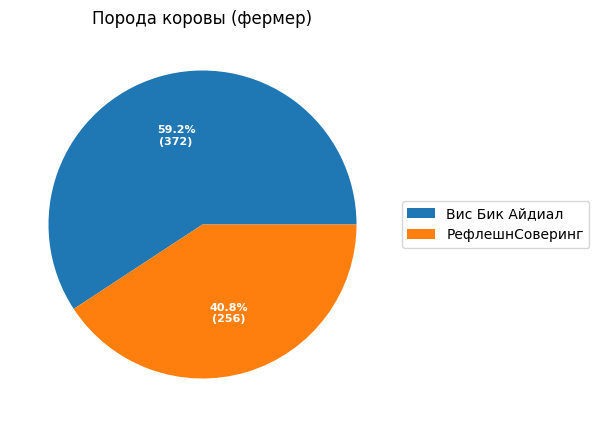

In [36]:
pie_chart(ferma_main_df, 'breed', 'Порода коровы (фермер)')

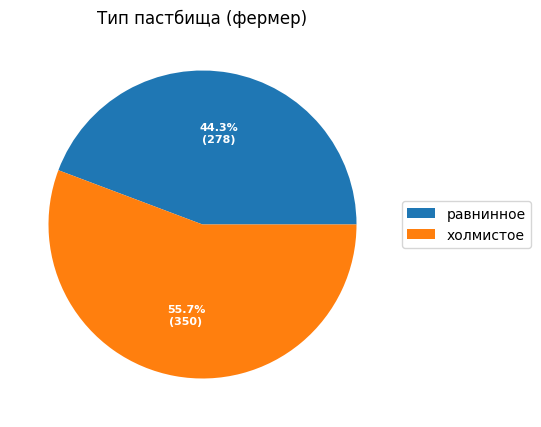

In [37]:
pie_chart(ferma_main_df, 'pasture_type', 'Тип пастбища (фермер)')

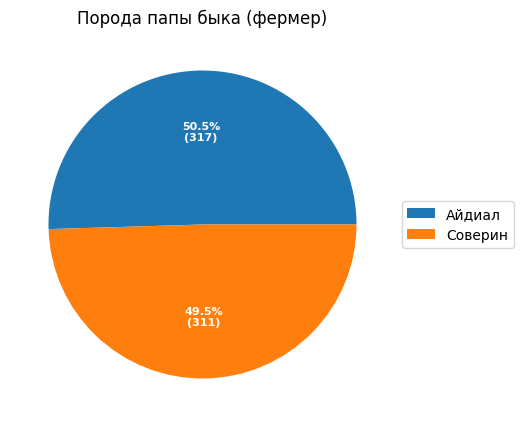

In [38]:
pie_chart(ferma_main_df, 'dadbull_breed', 'Порода папы быка (фермер)')

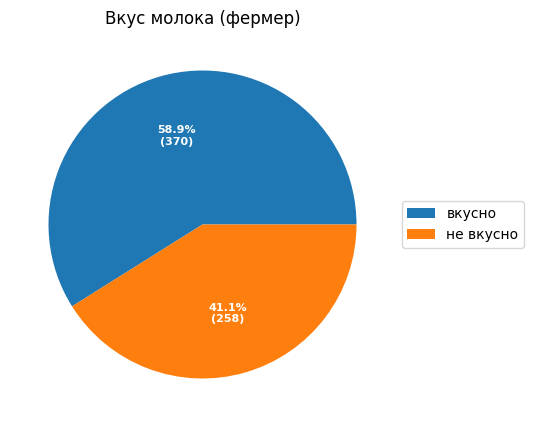

In [39]:
pie_chart(ferma_main_df, 'milk_taste', 'Вкус молока (фермер)')

На pie-диаграмме видно, что кол-во признака `вкусно` на 18% превышает таковое у `не вкусно` - возможно большее внимание нужно будет уделить метрике которая минимизирует ошибочный выбор признака `вкусно`.

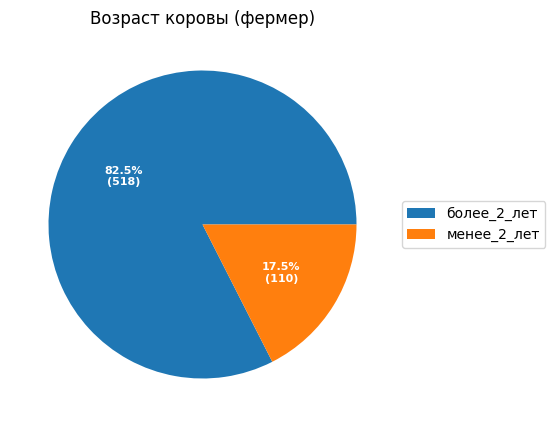

In [40]:
pie_chart(ferma_main_df, 'age', 'Возраст коровы (фермер)')

**Вывод:** В ходе стат. анализа датасета `ferma_main_df` выяснилось, что для количественных переменных соответ. распределения не имеют явно выраженного нормального распределения, в параметрах `fatness_perc` ('Жирность,%), `protein_perc` (Белок,%) и `yield_kg` (Удой, кг) выявлены выбросы - в последующем их возможно придется удалить. Для категориальных переменных определено следующее: большая часть коров (82,5%) старше 2 лет, имеют породу "Вис Бик Айдиал" (59.2%), пасется на холмистых пастбищах (55.7%), а порода папы-быка половины из всех фермерских коров - "Айдиал" (другая половина - "Соверин"). 60% молока фермером оценено как вкусное.

### Статистический анализ датасета о коровах «ЭкоФермы» `cow_buy_df`

count    20.000000
mean      3.577500
std       0.126818
min       3.340000
25%       3.510000
50%       3.590000
75%       3.650000
max       3.770000
Name: fatness_perc_act, dtype: float64

Усы боксплота: (3.299999999999999, 3.860000000000001)


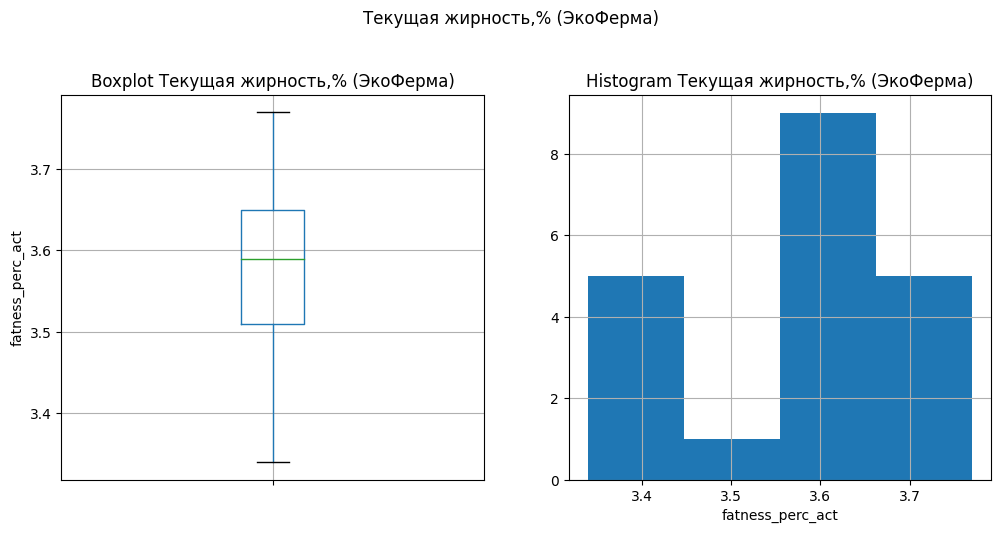

In [41]:
box_hist_plot(cow_buy_df, 'fatness_perc_act', 4, 'Текущая жирность,% (ЭкоФерма)')

count    20.000000
mean      3.069500
std       0.010339
min       3.046000
25%       3.064000
50%       3.074000
75%       3.076000
max       3.081000
Name: protein_perc_act, dtype: float64

Усы боксплота: (3.0460000000000003, 3.0940000000000003)


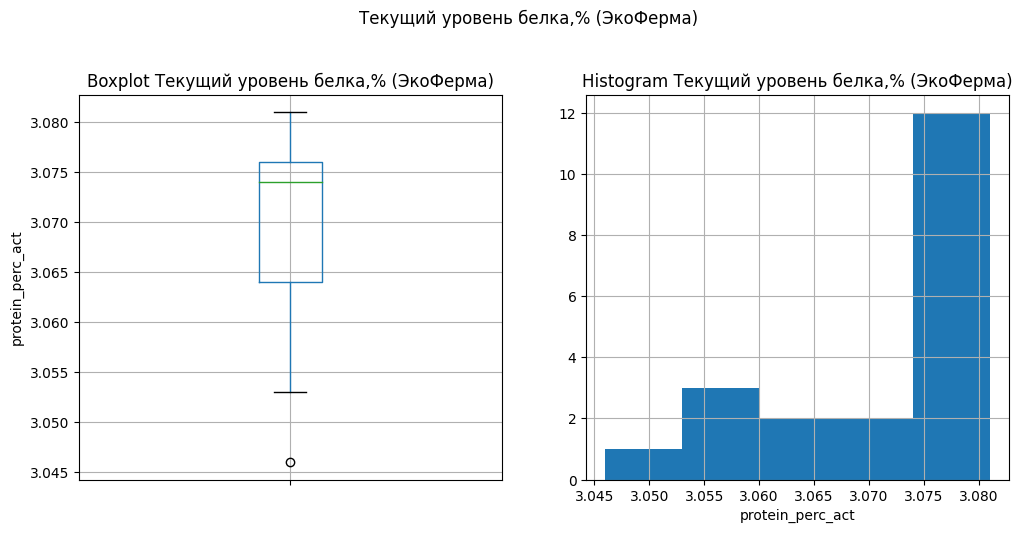

In [42]:
box_hist_plot(cow_buy_df, 'protein_perc_act', 5, 'Текущий уровень белка,% (ЭкоФерма)')

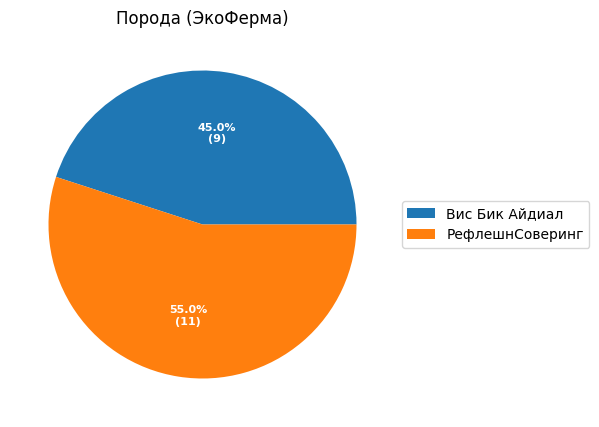

In [43]:
pie_chart(cow_buy_df, 'breed', 'Порода (ЭкоФерма)')

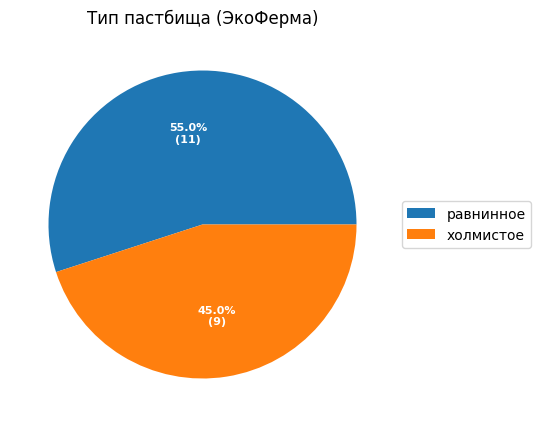

In [44]:
pie_chart(cow_buy_df, 'pasture_type', 'Тип пастбища (ЭкоФерма)')

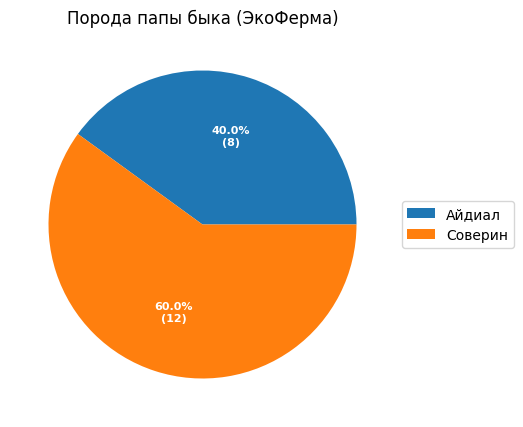

In [45]:
pie_chart(cow_buy_df, 'dadbull_breed', 'Порода папы быка (ЭкоФерма)')

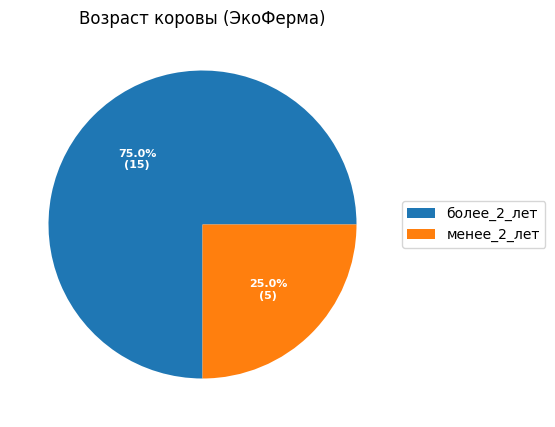

In [46]:
pie_chart(cow_buy_df, 'age', 'Возраст коровы (ЭкоФерма)')

**Вывод:** В ходе стат. анализа датасета коров "ЭкоФермы" `cow_buy_df` выяснилось, что для количественных переменных соответ. распределения еще менее близки к нормальным, при этом выбросы не выявлены. Для категориальных переменных определено следующее: большая часть коров породы РефлешинСоверинг, пасутся на равнине (по 55%), старше 2 лет (75%), порода их пап-быков (60%) "Соверин".

Также:

- явная бимодальность в данных: т.е. надо углублять в анализы подгрупп, прежде чем делать какие-то выводы.

- есть супервыброс по удою. Остальные точки на "ящиках с усами" - можно считать приемлимыми значениями на данном этапе. При моделировании (когда будем выполнять анализ остатков) посмотрим детальнее.

- факторы `СПО` и `Жирность`: есть подозрение, что его лучше перевести в категориальную шкалу, т.к. есть большая ассиметрия - скорее всего тут прячутся две-три группы.

## Корреляционный анализ признаков в датасете `ferma_main_df`

### Рассчет коэффициентов корреляции между всеми признаками.

Исключим `id` из heatmap и используем коэффициент корреляции Спирмена, который позволяет определять взаимосвязь признаков, распределения которых далеки от нормальных.

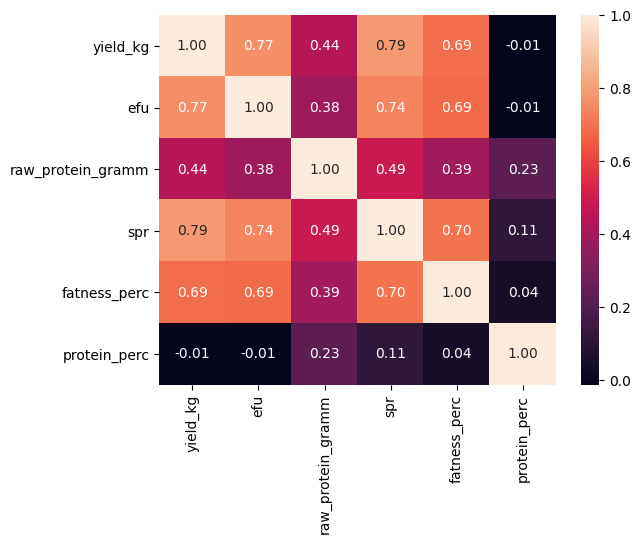

In [47]:
sns.heatmap(ferma_main_df.drop('id', axis=1).corr(method='spearman'), annot=True, fmt='.2f');

<div class="alert alert-warning">
<b>Комментарий 👉</b>


</div>

Из тепловой карты видно:
* Слабая связь наблюдается у `protein_perc` (содержание белков в молоке, %) со всеми остальными признаками (0.01 - 0.23);

* Умеренная связь наблюдается у `raw_protein_gramm` (cодержание сырого протеина в корме, г) со всеми остальными признаками (0.23 - 0.45);

* Заметная связь наблюдается у `fatness_perc` (содержание жиров в молоке, %) со всеми остальными признаками (0.69 - 0.7);

* Сильная связь наблюдается у `yield_kg` (масса молока, которую корова даёт в год, %), `efu` (показатель питательности корма коровы, %) и `spr` (Сахаро-протеиновое соотношение)

По итогу, очень высоких корреляций (> 0.9) не видно, скорее всего мультиколлинеарности нет

## Диаграммы рассеяния для признака `Удой` и всех количественных признаков с учётом значения категориальных.

In [48]:

cat_list = ['breed', 'pasture_type', 'dadbull_breed', 'milk_taste', 'age']
rus_dict = {'efu': 'ЭКЕ', 'raw_protein_gramm': 'Сырой протеин, г', 'spr': 'СПО', 'fatness_perc': 'Жирность,%', 'protein_perc': 'Белок,%',
            'breed': 'Порода', 'pasture_type': 'Тип пастбища', 'dadbull_breed': 'Порода папы_быка', 'milk_taste': 'Вкус молока', 'age': 'Возраст'}

# Вычисление числа строк и столбцов для построения
num_rows = (len(cat_list) + 1) // 2
num_cols = 2

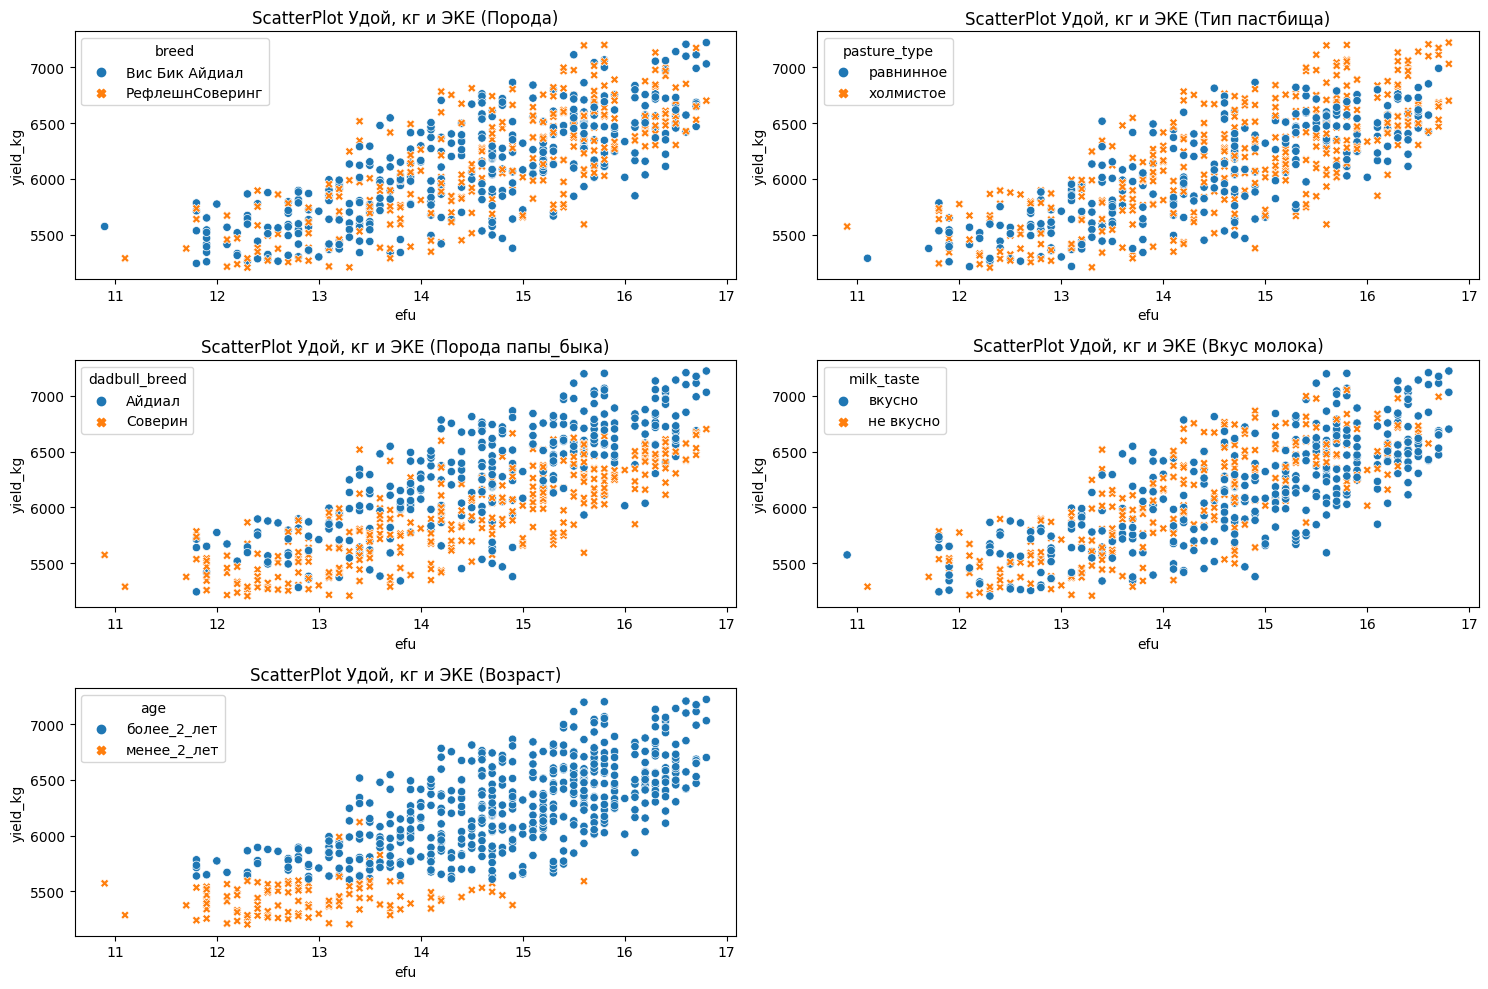

In [49]:
scat_plot("efu", ferma_main_df, cat_list, rus_dict, num_rows, num_cols)

Из диаграмм рассеяния для признака (`yield_kg`) (Удой, кг) и количественного признака `efu` (ЭКЕ (Энергетическая кормовая единица)) видно, что для всех категориальных переменных, зависимость между 2-мя ранее названными признаками нелинейна, исключение - категор. переменная `age` (Возраст), здесь для категор. признака `менее 2 лет` связь имеет более линейный характер, в сравнении с остальными диаграммами.

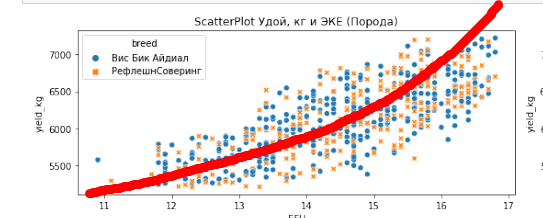

Отчётливо видно что ЭКЕ с удоем связно нелинейно (квадратично) и возведение ЭКЕ в степень наверняка улучшит линейную модель.

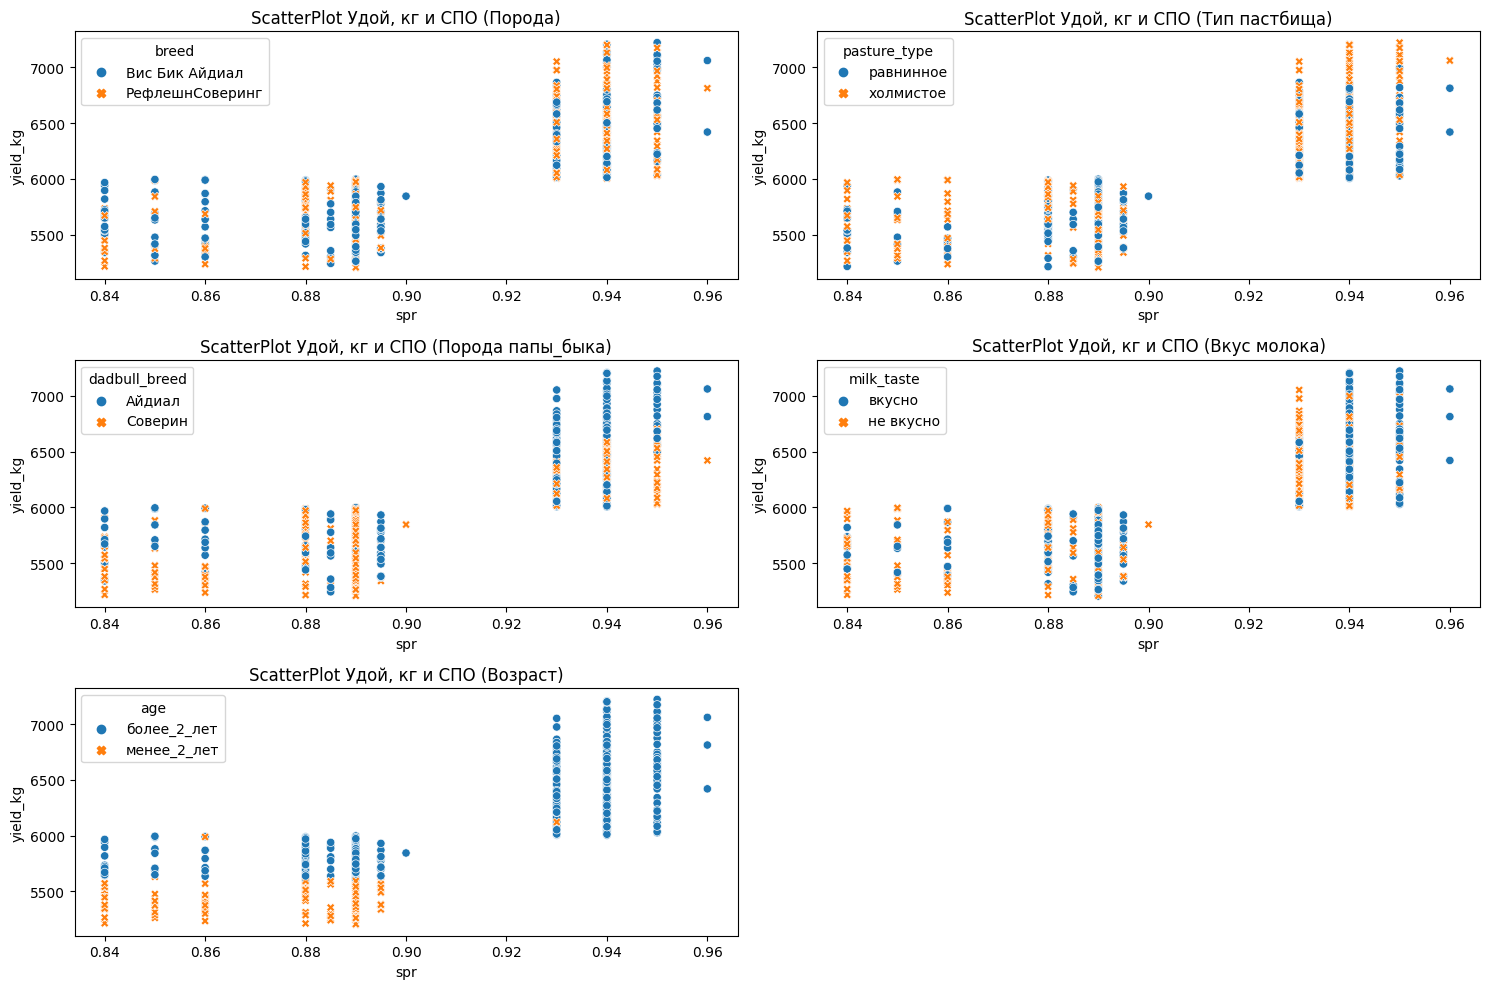

In [50]:
scat_plot("spr", ferma_main_df, cat_list, rus_dict, num_rows, num_cols)

Из диаграмм рассеяния для признака (`yield_kg`) (Удой, кг) и количественного признака `spr` (СПО (Сахаро-протеиновое соотношение корма)) для всех категориальных переменных видно, что зависимость между 2-мя ранее названными признаками несколько далека от линейной, при этом начиная со значения `spr` = 0.9 признак `Удой` повышается, но при этом для коров возрастом менее 2 лет это менее выражено.

Также видно что СПО имеет смысл перевести в категорию (на уровне между 0.91 - 0.92, примерно).

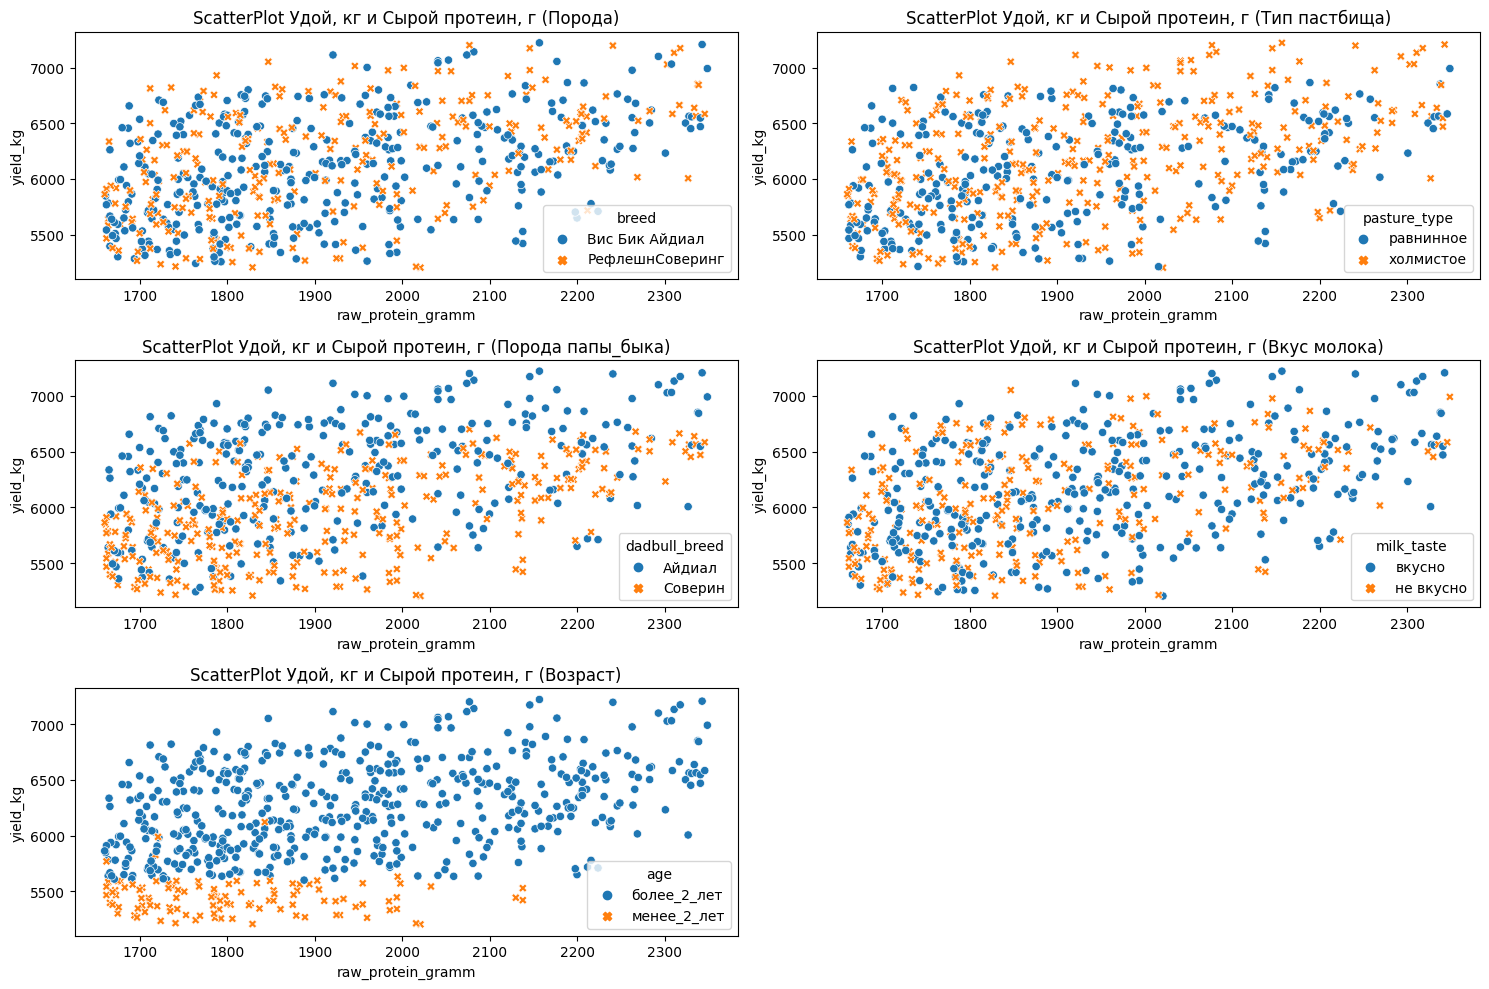

In [51]:
scat_plot("raw_protein_gramm", ferma_main_df, cat_list, rus_dict, num_rows, num_cols)

Из диаграмм рассеяния для признака (`yield_kg`) (Удой, кг) и количественного признака `raw_protein_gramm` (Сырой протеин, г (содержание сырого протеина в корме)) видно, что для всех категориальных переменных, зависимость между 2-мя ранее названными признаками почти не имеет линейного характера, исключение - категор. переменная `age` (Возраст), здесь для категор. признака `менее 2 лет` связь имеет более линейный характер, в сравнении с остальными диаграммами.

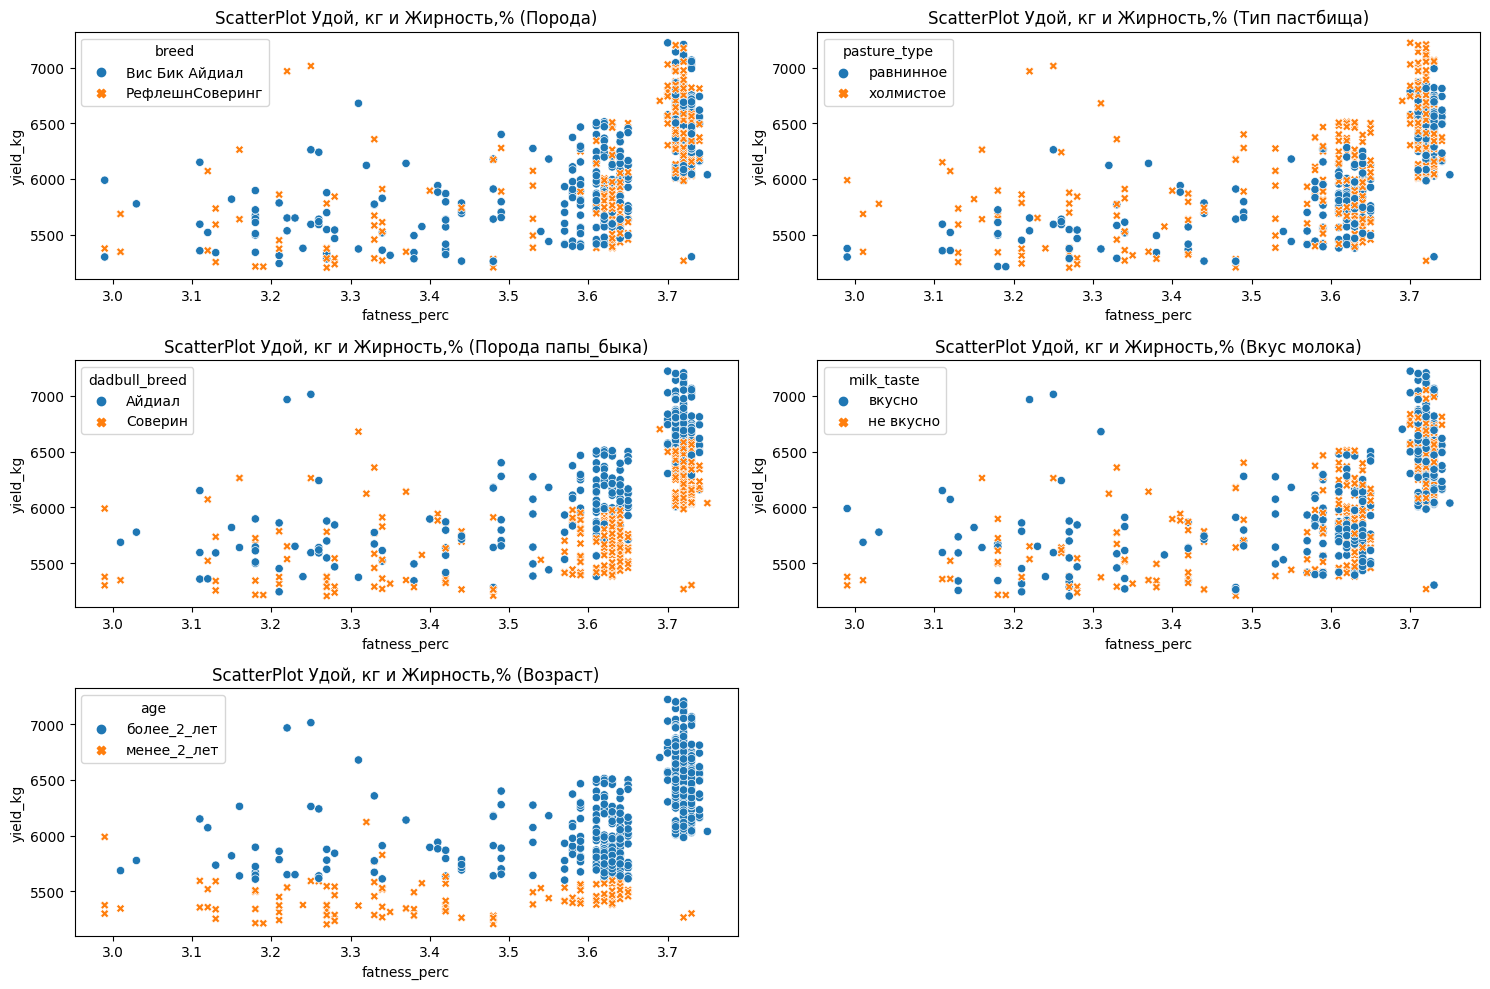

In [52]:
scat_plot("fatness_perc", ferma_main_df, cat_list, rus_dict, num_rows, num_cols)

Из диаграмм рассеяния для признака (`yield_kg`) (Удой, кг) и количественного признака `fatness_perc` (содержание жира в молоке) видно, что для всех категориальных переменных, зависимость между 2-мя ранее названными признаками не имеет линейного характера.

Также наблюдается 3 зоны с разной зависимостью с надоем: до 3.5, от 3.5 до 3.7, от 3.7.

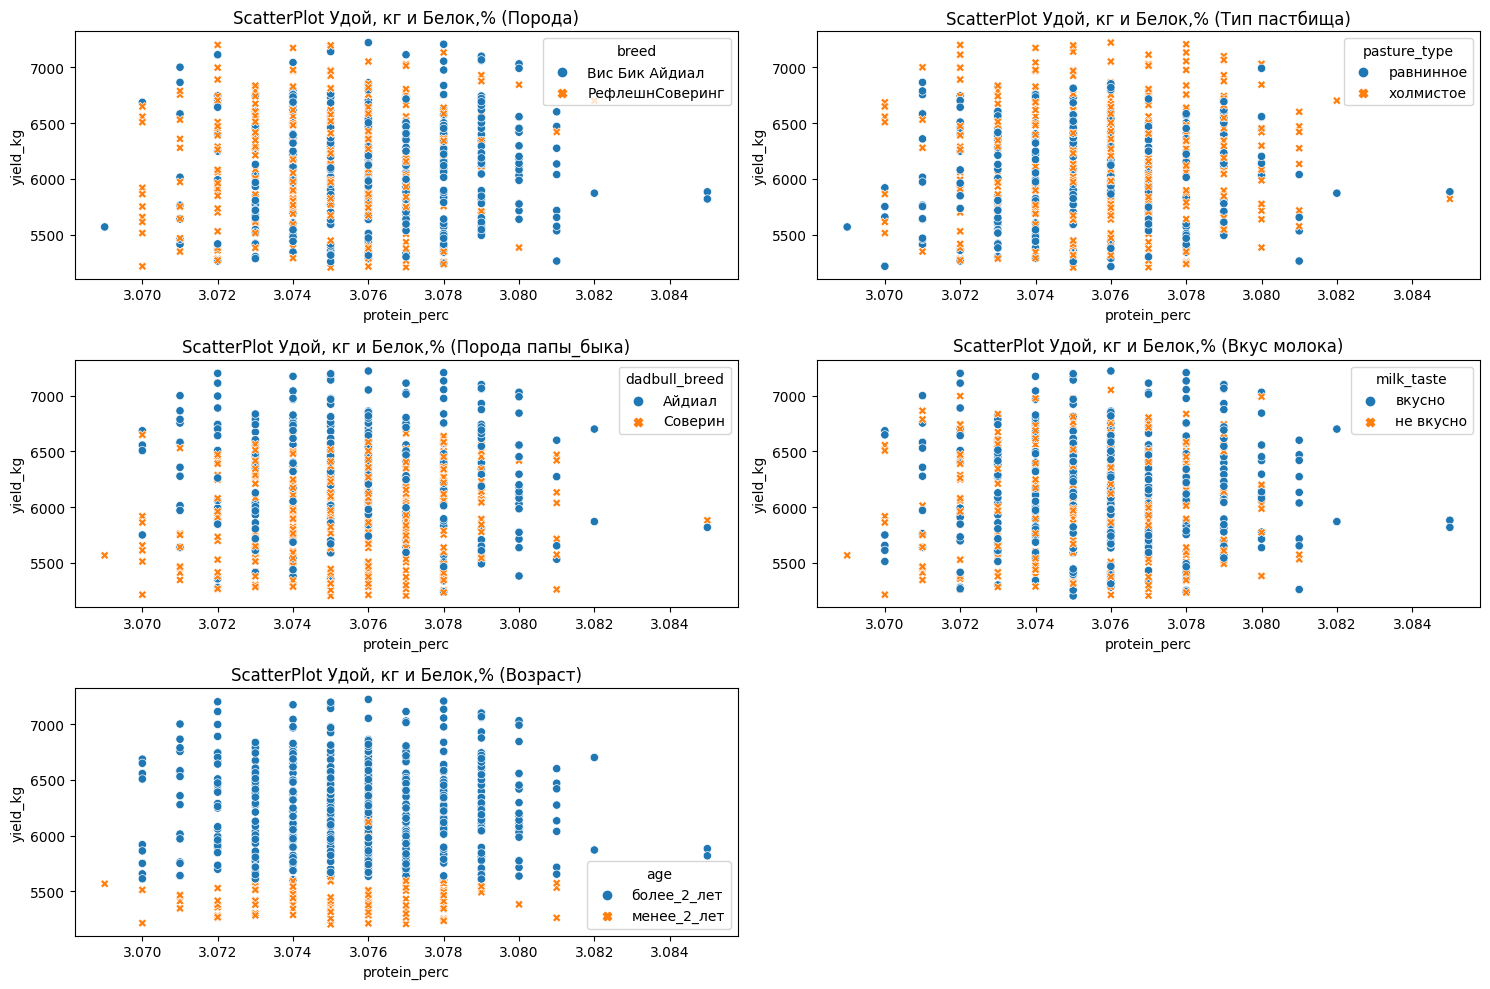

In [53]:
scat_plot("protein_perc", ferma_main_df, cat_list, rus_dict, num_rows, num_cols)

Из диаграмм рассеяния для признака (`yield_kg`) (Удой, кг) и количественного признака `protein_perc` (содержание белка в молоке) видно, что для всех категориальных переменных, зависимость между 2-мя ранее названными признаками имеет нелинейный характер.

**Вывод:** Очень слабовыраженная линейная зависимость признака `yield_kg` или `Удой, кг` наблюдается с количественными признаками `efu` (ЭКЕ (Энергетическая кормовая единица)) и `spr` (СПО (Сахаро-протеиновое соотношение)), с остальными количественными признаками (`raw_protein_gramm`, `fatness_perc`, `protein_perc`) либо еще слабее, либо вовсе отсутствует. Для дальнейшего решения задачи регресии возможно попробовать добавить новые признаки. Если брать за диапазон значений мультиколлинеарности 0.9 - 0.95, то между входными признаками датасета ее не наблюдается, при этом наиболее сильная корреляция (0,75) выявлена у признаков `spr` (СПО) и `efu` (ЭКЕ).  

Итого: 

- Явно заметны нелинейные связи между признаками, однозначно стоит создавать новые факторы.

- Отлично видно, что возраст влият на удой. Более молодые коровы меньше дают молока.

- По мультиколлинеарности: скорее нет (нет узкого облака). Т.к. графически мало что изменилось. Единственное, возможно иная зависимость между целевой и эке. Проверим это.

- Видно, что СПО используется только для возрастных коров.

- дополнительный вывод: в группах "порода_папы_быка" разный уровень корреляции по всем факторам. Т.е. есть отличия от корреляции по всей таблице. Скорее всего, "папа" сильнее влияет на удой, чем остальные факторы. Но посмотрим это уже в модели.

## Задача регресии

### Обучение 1-ой модели простой линейной регрессиии

Целевой признак нашей модели `yield_kg` или `Удой, кг`. В кач-ве входных признаков целесообразно взять `efu` (ЭКЕ (показатель питательности корма коровы)),  `spr` (СПР (отношение сахара к протеину в корме коровы)), `raw_protein_gramm` (содержание сырого протеина в корме (в граммах)) ,`breed` (порода коровы), `pasture_type` (ландшафт лугов, на которых паслась корова), `dadbull_breed` (порода папы коровы), `age` (возраст коровы (> или < 2 лет)).

c:\Users\User_home\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Значение коэффициента детерминации R2 модели: 0.7844078173416967
Значение MSE модели: 43887.015009660514
Значение RMSE модели: 209.4922791170608
Значение MAE модели: 164.2419446347492
------------------------------------------------------------


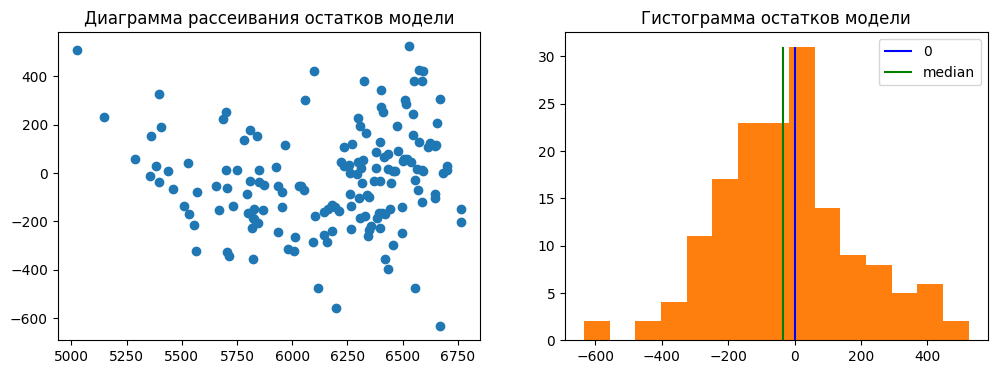

In [54]:
cat_cols = ['breed', 'pasture_type', 'dadbull_breed', 'age']
quant_cols = ['efu', 'spr', 'raw_protein_gramm']

# Разделение на тренировочную и тестовую выборки
X = ferma_main_df.drop('yield_kg', axis=1) 
y = ferma_main_df['yield_kg']

model_lr_1, predicts_1, encoder_1, scaler_1, X_train_1, X_test_1 = linear_model(ferma_main_df, cat_cols, quant_cols)

Коэффицент детерминации равен 78% - модель хорошо показывает себя в 78% случаев - неплохой результат. На гистограмме остатков видно что распределение остатков имеет вид близкий к нормальному и при этом среднее значение смещено влево от 0, т.е. модель часто дает значения выше истинных. На графике дисперсии видно, что для дисперсии остатков наблюдается гетероскедастичность (не постоянство дисперсии) от 6000 - модель использовать нельзя.

### Обучение 2-ой модели простой линейной регрессиии
Для этой модели устраним нелинейность между целевым признаком и входными признаками `spr` (СПО) и `efu` (ЭКЕ).

In [55]:
# Преобразование spr в бинарный признак и возведение efu в квадрат 
def spr_group(spr):
    if spr < 0.92:
        return 0
    else:
        return 1
    
ferma_main_df['spr_cat'] = ferma_main_df['spr'].apply(spr_group)
ferma_main_df['efu^2'] = ferma_main_df['efu'] ** 2

c:\Users\User_home\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Значение коэффициента детерминации R2 модели: 0.8173201325732171
Значение MSE модели: 37187.22072789052
Значение RMSE модели: 192.83988365452444
Значение MAE модели: 150.77150504303899
------------------------------------------------------------


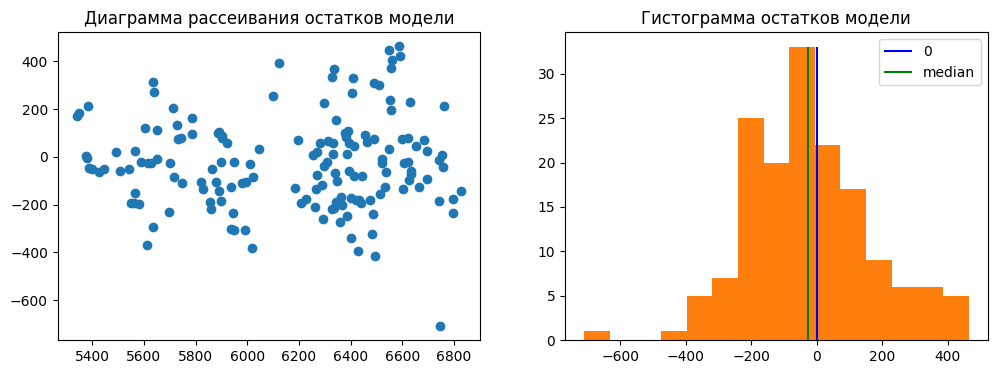

In [56]:
cat_cols = ['breed', 'pasture_type', 'dadbull_breed', 'age', 'spr_cat']
quant_cols = ['efu', 'efu^2','raw_protein_gramm']

model_lr_2, predicts_2, encoder_2, scaler_2, X_train_2, X_test_2 = linear_model(ferma_main_df, cat_cols, quant_cols)

По сравнению с предыдущей моделью, кач-во повысилось незначительно: значение коэффициента детерминации *R2* увеличилось на 5%, разброс остатков стал более равномерным и стабильным на всём диапозоне фактических данных. Это явное улучшение. Наблюдаются две зоны ошибок. Но разница дисперсии ошибок не систематическая, а выборочная. На гистограмме остатков никаких изменений не выявлено - модель по-прежнему дает значение выше истинных. Модель еще можно улучшить.

### Обучение 3-ей модели простой линейной регрессии
Для этой модели добавим категор. признак `dadbull_name` (имя папы коровы) из `ferma_dad_df` и устраним нелинейности между признаками, как в случае со 2-ой. 

In [57]:
ferma_main_df = ferma_main_df.merge(ferma_dad_df, on='id')

c:\Users\User_home\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Значение коэффициента детерминации R2 модели: 0.8288305584835518
Значение MSE модели: 34844.101286054894
Значение RMSE модели: 186.66574749014586
Значение MAE модели: 145.50602729083903
------------------------------------------------------------


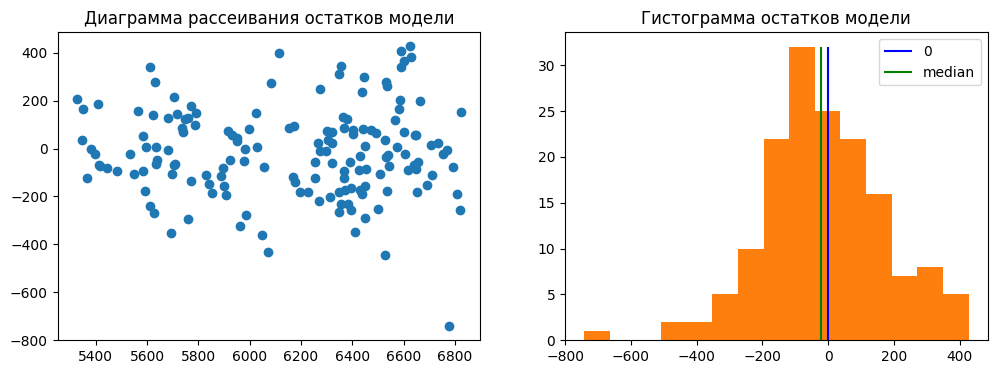

In [58]:
cat_cols = ['breed', 'pasture_type', 'dadbull_breed', 'age', 'spr_cat', 'dadbull_name']
quant_cols = ['efu', 'efu^2', 'raw_protein_gramm']

model_lr_3, predicts_3, encoder_3, scaler_3, X_train_3, X_test_3 = linear_model(ferma_main_df, cat_cols, quant_cols)

Кач-во 3-ей модели стало незначительно выше - коэффициент детерминации увеличился на 1% по сравнению со 2-ой моделью, распределения остатков не изменилось.

**Вывод**: Потенциал для улучшения модели всё ещё есть, но на текущий момент признаём модель качественной (остатки гомоскедастичны) и пригодной для работы. Посмотрим на точность модели.
</div>

На основе метрик качества моделей наиболее приемлимой является 3-ья. Рассчитаем для ее прогноза доверительный интервал (95%).

In [59]:
pred_df = pd.DataFrame(predicts_3)
std = pred_df.describe().T['std']
mean = pred_df.describe().T['mean']
n_root = pred_df.describe().T['count']**(1/2)

ci_low = mean - 1.96 * std / n_root
ci_up = mean + 1.96 * std / n_root

print(f'Границы доверительного интервала: нижняя {int(ci_low)}; верхняя: {int(ci_up)}')

Границы доверительного интервала: нижняя 6092; верхняя: 6222


### Прогноз удоя коров "ЭкоФермы" по наилучшей модели

In [60]:
# Добавим средние значения признаков "efu", "spr", "raw_protein_gramm" и столбцы 3-ей модели к "cow_buy_df" 
cow_buy_df['efu'] = 1.05 * ferma_main_df['efu'].mean()
cow_buy_df['spr'] = 1.05 * ferma_main_df['spr'].mean()
cow_buy_df['raw_protein_gramm'] = 1.05 * ferma_main_df['raw_protein_gramm'].mean()

cow_buy_df['spr_cat'] = cow_buy_df['spr'].apply(spr_group)
cow_buy_df['efu^2'] = cow_buy_df['efu'] ** 2

In [61]:
# Подготовка данных cow_buy_df (масштабирование и кодификация)
X_pred = cow_buy_df.copy()

# Кодирование категор. признаков выборки для прогноза
X_pred_ohe = encoder_3.transform(X_pred[cat_cols])
encoder_col_names = encoder_3.get_feature_names_out()
df_pred_ohe = pd.DataFrame(X_pred_ohe, columns=encoder_col_names) 

# Масштабирование колич. признаков 
X_pred_scaled = scaler_3.transform(X_pred[quant_cols])
df_pred_scaled = pd.DataFrame(X_pred_scaled, columns=quant_cols) 

X_pred = pd.concat([df_pred_scaled, df_pred_ohe], axis=1)
predicts = model_lr_3.predict(X_pred)

In [62]:
# Посмотрим на полученный рез-тат
predicts

array([6581.06917531, 6308.70183835, 6263.0249061 , 6571.7631311 ,
       6525.08219609, 6341.47036315, 6581.06917531, 6541.43414119,
       6263.0249061 , 6339.03082827, 6324.46512711, 6574.20266598,
       6581.06917531, 6065.24229799, 6263.0249061 , 6571.7631311 ,
       6324.46512711, 6341.47036315, 6541.43414119, 6525.08219609])

**Вывод**: Для решения задачи линейной регрессии с целевым признаком `Удой` было обучено и протестировано 3 модели с использованием метрик $R^2$, MSE, MAE, RMSE. Наилучшей (но не значительно) оказалась 3-ья модель, с дополнительно введеными категориальными и числовыми признаками, и именно с ее помощью были спрогнозированы удои приобретаемых коров.

## Задача классификации

### Модель логистической регрессии ("Вкус молока" - целевой признак)

Значение метрики accuracy: 0.62
Значение метрики recall: 0.86
Значение метрики precision: 0.61
---------------------------------
Матрица ошибок


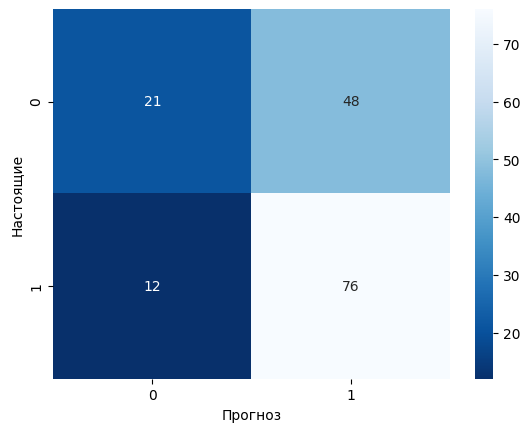

In [63]:
# Разделение на тренировочную и тестовую выборки
X = ferma_main_df.drop('milk_taste', axis=1) 
y = ferma_main_df['milk_taste']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE 
)

# Кодирование таргета `milk_taste` с ручной выставкой классов
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['не вкусно', 'вкусно'])
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Обучение модели логистической регрессии
model_clf = LogisticRegression()
model_clf.fit(X_train_3, y_train_encoded)

# Оценка кач-ва модели 
predictions_clf = model_clf.predict(X_test_3)
acc = accuracy_score(y_test_encoded, predictions_clf)
rec = recall_score(y_test_encoded, predictions_clf)
prec = precision_score(y_test_encoded, predictions_clf)

print(f'Значение метрики accuracy: {round(acc,2)}') 
print(f'Значение метрики recall: {round(rec,2)}')
print(f'Значение метрики precision: {round(prec,2)}')   
print('---------------------------------')
print('Матрица ошибок')
cm = confusion_matrix(y_test_encoded, predictions_clf)
sns.heatmap(cm, annot=True, cmap='Blues_r')
plt.xlabel('Прогноз')
plt.ylabel('Настоящие');

In [64]:
label_encoder.inverse_transform([0, 1])

array(['не вкусно', 'вкусно'], dtype='<U9')

### Анализ модели логистической регрессии

С учетом того, что главное для фермера-заказчика получить *вкусное* молоко, то наиболее критичной ошибкой при покупке коров будет ошибка 2-ого рода (принять *невкусное* (0) за *вкусное* (1)) - т.е. необходимо свести FP к 0, максимизировав метрику Precision. Для этого будем проверять разные пороги разделения на классы модели и метрику.

In [65]:
# Таблица вероятностей принадлежности к классам
y_proba = model_clf.predict_proba(X_test_3)[:, 1]
probs_df = pd.DataFrame(zip(y_test_encoded, y_proba), columns=['y_test', 'y_proba']).sort_values(by='y_proba', ascending=False)

# Разобъем на 20 порогов значений
thrs = [round(i,2) for i in np.linspace(0.1,1,num = 20,endpoint=False)]

# Добавление столбцов с новыми предсказаниями в зависимости от порога
columns = []
for i in thrs:
    col_name = 'y_pred_' + str(i)
    columns.append(col_name)
    probs_df[col_name] = probs_df['y_proba'].apply(lambda x: 0 if x < i else 1)

# Создадим таблицу с параметром precision и recall
metrics_df = pd.DataFrame(columns=['Порог', 'Precision', 'Recall'])

for i in columns:
    precision_val = precision_score(probs_df['y_test'], probs_df[i])
    recall_val = recall_score(probs_df['y_test'], probs_df[i])
    metrics_df = metrics_df.append({'Порог': i, 'Precision': precision_val, 'Recall': recall_val}, ignore_index=True)

max_precision = metrics_df['Precision'].max()
thr_1 = (metrics_df.query('Precision == @max_precision')['Порог'].values[0])
min_recall = metrics_df.query('Precision == @max_precision')['Recall'].values[0]
print(f'Макс. Precision = {round(max_precision, 2)} с порогом разделения {thr_1} соответствует Recall = {round(min_recall, 2)}')

# for i in thrs:
#     cm_i = confusion_matrix(probs_df['y_test'], probs_df['y_pred_' + str(i)])
#     if cm_i[0][1] == 0:
#         print(f'Порог разделеления = {i} со значением Recall = {round(recall_score(probs_df["y_test"], probs_df["y_pred_" + str(i)]), 2)} и Precision = {round(precision_score(probs_df["y_test"], probs_df["y_pred_" + str(i)]), 2)}')
#         thr = i
#         break

Макс. Precision = 1.0 с порогом разделения y_pred_0.82 соответствует Recall = 0.08


c:\Users\User_home\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User_home\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Обученная модель логистической регрессии имеет невысокие показатели кач-ва: 38% ее прогнозов неверны. В ходе анализа изменения метрик *Recall* и *Precision* выявлено, что для сведения к 0 ошибке 2-ого рода для обученной модели необходимо увеличить порог принадлежности классов до 0.86:

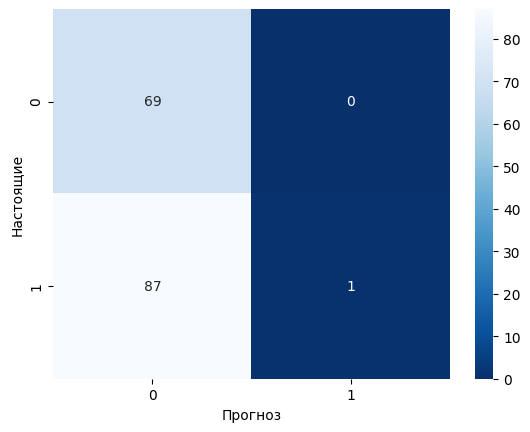

In [66]:
# Матрица ошибок модели на новом пороге
cm_1 = confusion_matrix(y_test_encoded, probs_df['y_pred_0.86'])
sns.heatmap(cm_1, annot=True, cmap='Blues_r')
plt.xlabel('Прогноз')
plt.ylabel('Настоящие');

С использованием метрики Precision удалось минимизировать FP-ошибку и получить максимальное количество единиц вкусного молока. Примем этот вариант.

### Прогноз вкуса молока коров "ЭкоФермы"

In [67]:
predicts_clf = model_clf.predict(X_pred)
predicts_clf

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

***Вывод:** Для решения задачи логистической регрессии с целевым признаком `Вкус молока` была обучена соответствующая модель. Полученная модель обладает невысокой точностью в 62% и более склона к совершению ошибок 1-ого рода. С целью минимизации этой самой ошибки были определены оценки вероятностей принадлежности к классам для различных пороговых значений: при значении 0.73 ошибка *FP* сводится к 0, а метрика *Precision* = 1, однако при этом увеличивается количество коров, молоко которых ошибочно м.б отнесено к категории *вкусное*.*

## Итоговые выводы

### Общий датафрейм с прогнозами для коров фирмы "ЭкоФерма"

In [68]:
cow_buy_df = cow_buy_df.drop(columns=['spr_cat', 'efu^2', 'efu', 'spr', 'raw_protein_gramm']).reset_index(drop=True)
predicts_df = pd.DataFrame(predicts, columns=['yield_kg'])
predicts_clf_df = pd.DataFrame(predicts_clf, columns=['taste'])
cow_buy_df_predicts = pd.concat([cow_buy_df, predicts_df, predicts_clf_df], axis=1)

cow_buy_df_predicts

,breed,pasture_type,dadbull_breed,dadbull_name,fatness_perc_act,protein_perc_act,age,yield_kg,taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6581.069175,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6308.701838,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6263.024906,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6571.763131,1
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6525.082196,1
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6341.470363,0
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6581.069175,1
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6541.434141,1
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6263.024906,1
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6339.030828,1


In [130]:
# Отберем коров с удоем больше 6000кг и вкусным молоком
cows_to_buy = cow_buy_df_predicts.query('yield_kg > 6000 and taste == 0').reset_index(drop=True)
cows_to_buy

,breed,pasture_type,dadbull_breed,dadbull_name,fatness_perc_act,protein_perc_act,age,yield_kg,taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6581.069175,0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6308.701838,0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6263.024906,0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6571.763131,0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6525.082196,0
5,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6581.069175,0
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6541.434141,0
7,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6263.024906,0
8,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6339.030828,0
9,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,6324.465127,0


Всего к покупке можно рекомендовать 18 коров данные по которым приведены в таблице выше.

Из стада коров "ЭкоФермы" 18 коров с высокой вероятностью (82%) будут давать удой более 6000кг и с вероятностью 62% их молоко будет вкусным. Для адекватной минимизации риска покупки коров, фермеру можно порекомендовать предоставить данные о том сколько минимум коров он собирается приобрести, или какой процент коров, дающих невкусное молоко для него считается приемлимым.

### Краткое описание результатов работы моделей

Для улучшения модели линейной регрессии были использованы методы, позволяющие учитывать нелинейную связь между признаками:
* Добавление признака, численнно равного квадрату соответсвующего (в нашем исследовании это `СПО` и `СПО в квадрате`)
* Преобразование численного признака имеющего нелинейную зависимость с таргетом в категориальный признак (`ЭКЕ`)

Возможно дальше улучшить модель регресии путем добавления признаков возведенных в определенную (2 и т.д.) степень, при этом важно не допустить переобучения модели.

Наиболее важными метриками классификации являются *Precision* (определяет вероятность ошибки 1-ого рода или значения FP) и *Recall* (определяет вероятность ошибки 2-ого рода или значения FN). В зависимости от требований поставленной задачи определяется по какой метрике будет производиться анализ рисков, корректироваться расчеты или определяться некоторый компромисс между этими самыми метриками.
